# Text Analytics - Assignment 5

Grammatikopoulou Maria - f3352310

Phevos A. Margonis - f3352317

Moniaki Melina - f3352321

In [1]:
# !pip install --upgrade tensorflow 
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# !gzip -d cc.en.300.bin.gz
# !pip install transformers
# !pip install datasets
# !pip install accelerate
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import time
import re
# import fasttext

# ML libraries
from sklearn.metrics import (auc, classification_report,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Bidirectional, GRU, Lambda, BatchNormalization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Add
# NLTK
import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Progress bar
from tqdm import tqdm

# NLP libraries
# Install spacy
# !pip install spacy
# Download the English language model
# !python -m spacy download en
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

2024-03-08 15:48:37.473839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 15:48:37.473919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 15:48:37.540533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 15:48:39.219384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
TARGET_NAMES = ['negative', 'positive']

csv_file_path = "IMDB Dataset.csv"
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df.head())
df.shape
#df['review'][3]
#sns.countplot(x="sentiment", data=df)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


(50000, 2)

In [ ]:
# oldDF = df
# df = df.iloc[:5000,:]

In [3]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)


def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()
    # Remove html tags
    sentence = remove_tags(sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
    # # Remove Stopwords
    # pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    # sentence = pattern.sub('', sentence)

    return sentence


# Calling preprocessing_text function on df
X = []
sentences = list(df['review'])
for sen in tqdm(sentences, desc='Preprocessing: '):
    X.append(preprocess_text(sen))
    
print(X[0])

Preprocessing: 100%|██████████| 50000/50000 [00:07<00:00, 6400.35it/s]

one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare forget pretty pictures

In [4]:
# Converting sentiment labels to 0 & 1
y = df['sentiment']
y = np.array(list(map(lambda x: 1 if x == "positive" else 0, y)))

In [5]:
# Split the data into training (70%) and temporary data (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the temporary data into testing (50%) and validation (50%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print('Train samples: {}'.format(len(X_train)))
print('Val samples: {}'.format(len(X_val)))
print('Test samples: {}'.format(len(X_test)))

Train samples: 35000
Val samples: 7500
Test samples: 7500


In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                             max_features=5000,
                             sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [9]:
# Reduce dimensionality using svd 5000 --> 500
svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

In [10]:

def my_auc_report(y_true, y_pred, title='UNK') -> None:
    """
    Inputs the y_true and y_pred,
    Prints the PR-AUC for each class
    """
    print(f"=== PR-AUC for {title} ===")
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 0], pos_label=0)
    area = auc(recall, precision)
    print(f"PR-AUC for class 0: {area*100:.2f}%")
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    area = auc(recall, precision)
    print(f"PR-AUC for class 1: {area*100:.2f}%\n")

##Dummy classifier
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(X_train_svd, y_train)
majority_val_accuracy = baseline.score(X_val_svd, y_val)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
model = baseline
# Classification Reports
predictions = model.predict(X_train_svd)
print(classification_report(y_train, predictions, zero_division=0, target_names=TARGET_NAMES))
predictions = model.predict(X_val_svd)
print(classification_report(y_val, predictions, zero_division=0, target_names=TARGET_NAMES))
predictions = model.predict(X_test_svd)
print(classification_report(y_test, predictions, zero_division=0, target_names=TARGET_NAMES))

# Prepare the predictions for PR-AUC
predictions_train = model.predict_proba(X_train_svd)
predictions_val = model.predict_proba(X_val_svd)
predictions_test = model.predict_proba(X_test_svd)
# PR-AUC report
my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')

Training took: 0.002635955810546875 seconds 

              precision    recall  f1-score   support

    negative       0.50      1.00      0.67     17589
    positive       0.00      0.00      0.00     17411

    accuracy                           0.50     35000
   macro avg       0.25      0.50      0.33     35000
weighted avg       0.25      0.50      0.34     35000

              precision    recall  f1-score   support

    negative       0.50      1.00      0.66      3722
    positive       0.00      0.00      0.00      3778

    accuracy                           0.50      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.25      0.50      0.33      7500

              precision    recall  f1-score   support

    negative       0.49      1.00      0.66      3689
    positive       0.00      0.00      0.00      3811

    accuracy                           0.49      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.24     

In [11]:
clf = LogisticRegression()
clf.fit(X_train_svd, y_train)
logit_val_accuracy = clf.score(X_val_svd, y_val)

# Evaluate
model = clf
# Classification Reports
predictions = model.predict(X_train_svd)
print(classification_report(y_train, predictions, target_names=TARGET_NAMES))
predictions = model.predict(X_val_svd)
print(classification_report(y_val, predictions, target_names=TARGET_NAMES))
predictions = model.predict(X_test_svd)
print(classification_report(y_test, predictions, target_names=TARGET_NAMES))

# Prepare the predictions for PR-AUC
predictions_train = model.predict_proba(X_train_svd)
predictions_val = model.predict_proba(X_val_svd)
predictions_test = model.predict_proba(X_test_svd)
# PR-AUC report
my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')



              precision    recall  f1-score   support

    negative       0.89      0.88      0.89     17589
    positive       0.88      0.90      0.89     17411

    accuracy                           0.89     35000
   macro avg       0.89      0.89      0.89     35000
weighted avg       0.89      0.89      0.89     35000

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      3722
    positive       0.88      0.90      0.89      3778

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      3689
    positive       0.88      0.89      0.89      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

=== PR-AUC for Trai

## Transformers

In [12]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
bert_clf = TFAutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased', 
                                                                num_labels=1)
bert_clf.summary()

/home/foivos/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-03-08 15:50:35.875871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 15:50:35.881948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 15:50:35.882155: I external/local_xla/xla/stream_executo

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
def tokenize_text(data, tokenizer, max_length=250):
  return tokenizer(data, add_special_tokens=True, padding='max_length',
                   max_length=max_length, truncation=True, return_tensors='tf')

bert_train = tokenize_text(X_train, bert_tokenizer)
bert_val = tokenize_text(X_val, bert_tokenizer)
bert_test = tokenize_text(X_test, bert_tokenizer)

In [14]:
bert_train

{'input_ids': <tf.Tensor: shape=(35000, 250), dtype=int32, numpy=
array([[ 101, 2004, 2172, ...,    0,    0,    0],
       [ 101, 2023, 2001, ...,    0,    0,    0],
       [ 101, 2025, 4531, ...,    0,    0,    0],
       ...,
       [ 101, 4468, 2023, ...,    0,    0,    0],
       [ 101, 2023, 2537, ...,    0,    0,    0],
       [ 101, 2023, 2003, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(35000, 250), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [16]:
bert_clf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-6),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)
# Train the model ==============================================
start_training_time = time.time()
history = bert_clf.fit(
    x=[bert_train['input_ids'],
       bert_train['attention_mask']],
    y=y_train,
    epochs=10,
    batch_size=8,
    validation_data=([bert_val['input_ids'],
                      bert_val['attention_mask']],
                     y_val),
    callbacks=[early_stopping]
)
end_training_time = time.time()
print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')

# Same the complete model once ==================================
bert_clf.save('checkpoints/distilbert_ex1')

Epoch 1/10
4375/4375 [==============================] - 1409s 318ms/step - loss: 0.2221 - binary_accuracy: 0.9100 - val_loss: 0.2372 - val_binary_accuracy: 0.9101
Epoch 2/10
4375/4375 [==============================] - 1388s 317ms/step - loss: 0.1888 - binary_accuracy: 0.9262 - val_loss: 0.3153 - val_binary_accuracy: 0.8916
Epoch 3/10
4375/4375 [==============================] - 1389s 318ms/step - loss: 0.1584 - binary_accuracy: 0.9404 - val_loss: 0.2342 - val_binary_accuracy: 0.9116
Epoch 4/10
4375/4375 [==============================] - 1391s 318ms/step - loss: 0.1324 - binary_accuracy: 0.9529 - val_loss: 0.2466 - val_binary_accuracy: 0.9105
Epoch 5/10
4375/4375 [==============================] - 1391s 318ms/step - loss: 0.1087 - binary_accuracy: 0.9623 - val_loss: 0.2588 - val_binary_accuracy: 0.9128
Epoch 6/10
4375/4375 [==============================] - 1392s 318ms/step - loss: 0.0899 - binary_accuracy: 0.9693 - val_loss: 0.2891 - val_binary_accuracy: 0.9119

Training time: 02:19:

INFO:tensorflow:Assets written to: checkpoints/distilbert_ex1/assets


INFO:tensorflow:Assets written to: checkpoints/distilbert_ex1/assets


In [ ]:
loss, accuracy = bert_clf.evaluate([bert_val["input_ids"], bert_val["attention_mask"]], y_val, verbose=1)
print(f"Loss: {loss:.4f}\nAccuracy: {accuracy*100:.4f}%")

## Loss & Accuracy Curves

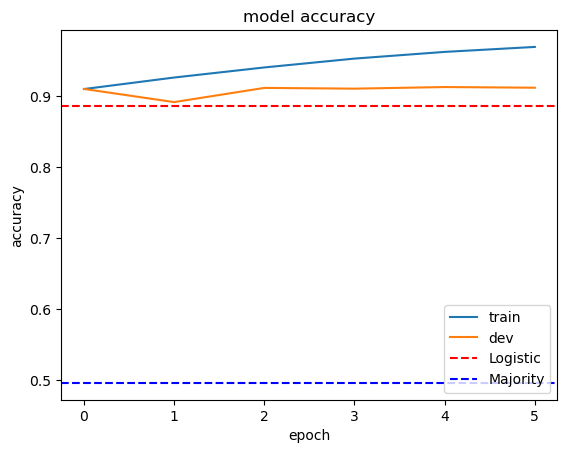

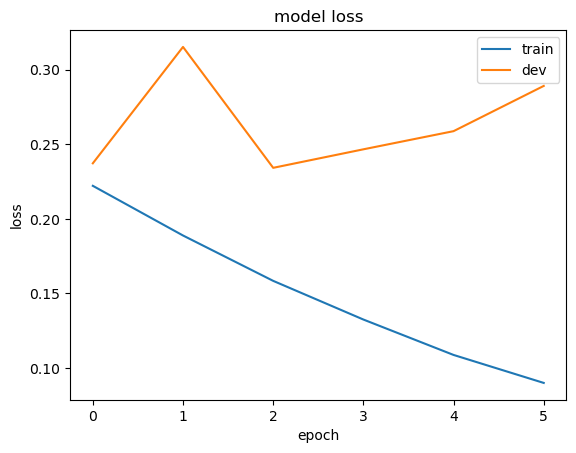

In [17]:

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axhline(y=logit_val_accuracy, color='red', linestyle='--', label='Logistic')
plt.axhline(y=majority_val_accuracy, color='blue', linestyle='--', label='Majority')
plt.legend(['train', 'dev', 'Logistic', 'Majority'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [ ]:
bert_clf = tf.keras.models.load_model('checkpoints/distilbert_ex1')

## Evaluate model

In [23]:
predictions = bert_clf.predict({'input_ids': bert_train['input_ids'], 'attention_mask': bert_train['attention_mask']})
predictions_activated = tf.nn.sigmoid(predictions.logits)  # Remove .logits in load_model
predictions_classified = (predictions_activated > 0.5).numpy()
print(classification_report(y_train, predictions_classified, target_names=TARGET_NAMES))

predictions = bert_clf.predict({'input_ids': bert_val['input_ids'], 'attention_mask': bert_val['attention_mask']})
predictions_activated = tf.nn.sigmoid(predictions.logits)  # Remove .logits in load_model
predictions_classified = (predictions_activated > 0.5).numpy()
print(classification_report(y_val, predictions_classified, target_names=TARGET_NAMES))

predictions = bert_clf.predict({'input_ids': bert_test['input_ids'], 'attention_mask': bert_test['attention_mask']})
predictions_activated = tf.nn.sigmoid(predictions.logits)  # Remove .logits in load_model
predictions_classified = (predictions_activated > 0.5).numpy()
print(classification_report(y_test, predictions_classified, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

    negative       0.97      0.96      0.97     17589
    positive       0.96      0.97      0.97     17411

    accuracy                           0.97     35000
   macro avg       0.97      0.97      0.97     35000
weighted avg       0.97      0.97      0.97     35000

235/235 [==============================] - 84s 357ms/step
              precision    recall  f1-score   support

    negative       0.92      0.91      0.91      3722
    positive       0.91      0.92      0.92      3778

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500

235/235 [==============================] - 84s 356ms/step
              precision    recall  f1-score   support

    negative       0.92      0.91      0.91      3689
    positive       0.91      0.92      0.92      3811

    accuracy                           0.91      7500
   macro avg

In [29]:
def custom_pred_proba(X) -> np.ndarray[tuple[float, float]]:
    ''' Calculates the classic .predict_proba() for the X input feature matix,
        because it is needed for the precision_recall_curve.
        Returns an array: [P(x=0), P(x=1)] '''
    pred = bert_clf.predict({'input_ids': X['input_ids'], 'attention_mask': X['attention_mask']})
    pred = tf.nn.sigmoid(pred.logits)  # Remove .logits in load_model
    return np.hstack((1-pred, pred))


# Prepare predictions for PR-AUC
predictions_train = custom_pred_proba(bert_train)
predictions_val = custom_pred_proba(bert_val)
predictions_test = custom_pred_proba(bert_test)
# PR-AUC report
my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')

235/235 [==============================] - 84s 358ms/step
=== PR-AUC for Train ===
PR-AUC for class 0: 99.11%
PR-AUC for class 1: 99.04%

=== PR-AUC for Validation ===
PR-AUC for class 0: 97.09%
PR-AUC for class 1: 97.14%

=== PR-AUC for Test ===
PR-AUC for class 0: 97.29%
PR-AUC for class 1: 97.22%

